In [1]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle
from train_toy import RoutingIter, RoutingPoint
from nets import _CapsNet

In [23]:
def car2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return theta, r


def plot_routing_steps(batch_index, routing_point, norm_c_ji, show_v, plot_pred_mean):

    b, rp = batch_index, routing_point

    # print info
    print("Epoch: {}".format(rp.epoch))
    print("Iter: {}".format(rp.iter))
    print("Accuracy {:.4f}".format(rp.acc))
    fig = plt.figure(figsize=(14, 4))

    # prediction vectors
    u_jin = rp.u_jin[b, :, :, :]

    # latent point used to generate data
    latent = rp.latent[b, :]

    # label of gaussian from which latent point sampled
    label = rp.label[b]

    print("Label {}".format(label))

    # colors0,114,178
    green = "#0072B2" #[0.2, 0.8, 0.2]   # true class / label class
    red = "#D55E00" #[0.8, 0.2, 0.2]     # wrong class

    def get_ymax():
        r_max = 0
        
        if show_v: 
            for step in range(3): 
                x = rp.routing_iters[step].v_jn[b, :, 0]
                y = rp.routing_iters[step].v_jn[b, :, 1]

                _, r = car2pol(x, y)
                if np.max(r) > r_max:
                    r_max = np.max(r)
        
        _, r_l0 = car2pol(u_jin[0, :, 0] , u_jin[0, :, 1])
        _, r_l1 = car2pol(u_jin[1, :, 0] , u_jin[1, :, 1])
        r_max = max(np.max(r_l0), np.max(r_l1), r_max)
        return r_max
    
    ylim = get_ymax()
    ylim += ylim * 0.08
            
    def shared_properties(axes):

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_ylim(0,ylim)
        ax.spines["polar"].set_visible(False)

        return axes

    for step in range(3): 

        c_ji = rp.routing_iters[step].c_ji[b, :, :]
        s_jn = rp.routing_iters[step].s_jn[b, :, :]
        v_jn = rp.routing_iters[step].v_jn[b, :, :]
        logits_j = _CapsNet.compute_logits(torch.from_numpy(v_jn))

        ax = fig.add_subplot(1,3,step+1, polar=True)
        ax.set_xlabel('Step {} \n logit class 0: {:.4f} \nlogit class 1: {:.4f}'.format(step, logits_j[0], logits_j[1]), fontsize=12)
        ax = shared_properties(ax)
        
        if norm_c_ji and step > 0:
            c_ji_norm = (c_ji - np.min(c_ji)) / (np.max(c_ji) - np.min(c_ji))
            c_ji_area = 100 * c_ji_norm
        else: 
            c_ji_area = 100 * c_ji
        
        if step == 2: 
            print(f"Biggest abs change: {np.max(np.abs(c_ji / 0.5 - 1)) * 100:0.2f}%")
        
        for j in range(2):

            color = green if j==label else red

            # predictions weighted by c_ij
            c_i_area = c_ji_area[j, :]
            
            ax.scatter(*car2pol(u_jin[j, :, 0] , u_jin[j, :, 1]), s=c_i_area, facecolors='none', edgecolors=color)

            if plot_pred_mean: 
                ax.scatter(*car2pol(s_jn[j, 0], s_jn[j, 1]), marker="o", c=color)
            
            # squashed prediction mean
            v_theta, v_r = car2pol(v_jn[j, 0], v_jn[j, 1])
            if show_v:
                ax.scatter(v_theta, v_r, marker="D", c=color)
            ax.plot([v_theta, v_theta],[0, 1],lw=1, c=color)
            


Epoch: 1
Iter: 0
Accuracy 0.7125
Label 0
Biggest abs change: 0.82%


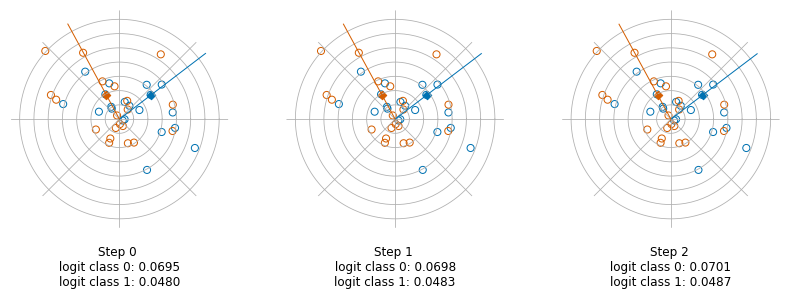

In [24]:
with open("experiments/2dgaussian/routing_points", "rb") as f:
    routing_points = pickle.load(f)
    
routing_point = routing_points[30]     # routing point index
batch_index =  62                  # batch_index
plot_routing_steps(batch_index, routing_point, norm_c_ji=False, show_v=True, plot_pred_mean=False)

Epoch: 18
Iter: 5
Accuracy 0.9766
Label 0
Biggest abs change: 25.20%


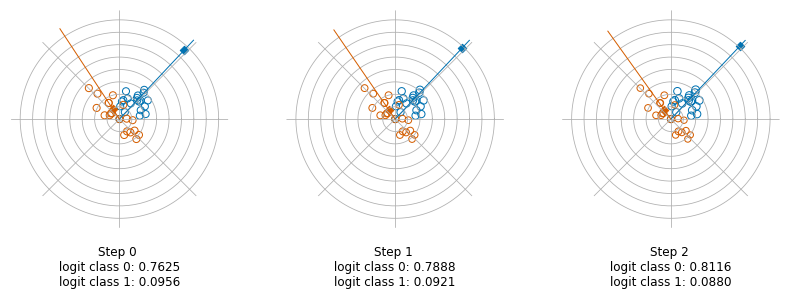

In [25]:
with open("experiments/2dgaussian/routing_points", "rb") as f:
    routing_points = pickle.load(f)
    
routing_point = routing_points[550]     # routing point index
batch_index =  126                      # batch_index
plot_routing_steps(batch_index, routing_point, norm_c_ji=False, show_v=True, plot_pred_mean=False)

Epoch: 18
Iter: 5
Accuracy 0.9766
Label 0
Biggest abs change: 25.20%


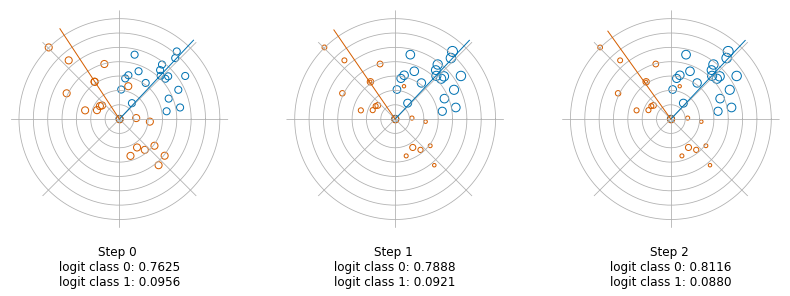

In [26]:
with open("experiments/2dgaussian/routing_points", "rb") as f:
    routing_points = pickle.load(f)
    
routing_point = routing_points[550]     # routing point index
batch_index =  126                      # batch_index
plot_routing_steps(batch_index, routing_point, norm_c_ji=True, show_v=False, plot_pred_mean=False)